In [80]:
!pip install -qU "langchain[groq]"

In [81]:
!pip install -U langgraph

In [82]:
!pip install -qU langchain-google-genai

In [83]:
import getpass
import os
# Create your views here.

from google.colab import userdata



from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END

from langchain_core.messages import BaseMessage

In [84]:
os.environ["GOOGLE_API_KEY"] = userdata.get('gen_ai')

if not os.getenv("GOOGLE_API_KEY"):
        os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter your Google API Key: ")

from langchain.chat_models import init_chat_model

model = init_chat_model("gemini-2.5-flash", model_provider="google_genai")


from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.prompts import ChatPromptTemplate
import json

In [85]:
docs_details = {

        "1": { "name": "syllabus","type": "pdf", "description": "it contains detailed syllabus of physics for this academic year", "path": "/docs/syllabus.pdf"},
        "2": {"name": "class notes of newtons 3rd law of motion","type": "pdf", "description": "it contains whatever discussed in the class on newtons 3rd law of motion", "path": "/content/newtons_third_law_of_motion.pdf"}

        }

stu_scores = {

                "1": { "test_score": "6", "weak_topics": ["newtons 1st law of motion"], "test_topic": "newtons 1st and 2nd laws of motion","test_date": "01/01/2022" },


    }

class State(TypedDict):

  messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

# Quiz Maker
it will first quiz topic from student find the relevent documents from documents which are uploaded the teacher, Analysis the student previous performance, suggest to student to prequalilties of the quiz and revison needed topics based on this previous performance, generate quiz quesctions,options, correct answer, explanation of answer

In [86]:
def document_loader(state: State):


        system_template = "You are a knowledgeable and strict teacher. Your task is to select only the relevant documents needed to prepare a quiz on the given topic. The available documents are provided as a Python dictionary, and the quiz topic is {topic}. Each document includes a description. Carefully read the topic and the document descriptions, then select only the documents that are relevant for preparing a quiz on the given topic. Return your answer only as a Python dictionary in the exact same format as the input documents dictionary, but include only the selected documents. Do not add any explanations, comments, or text outside the dictionary. Do not mention that the output is in any format (such as Python dictionary or JSON). Output must strictly contain only the required documents in dictionary format and nothing else. and there is no restriction on number of documents need to select "
        user_message = "Available documents details {doc_details} "

        prompt_template = ChatPromptTemplate.from_messages([

            ("system", system_template),
            ("user", user_message)

        ])

        prompt = prompt_template.invoke({"doc_details": docs_details, "topic": "newtons 3rd law of motion"})

        responce = model.invoke(prompt)





        return {'messages': [responce.content]}

In [87]:
def prev_analysis(state: State):

        system_template = "you are a good teacher, you need to give warning to the student of what topics student need to revise or imporve based on his previous tests performances and weak topics to attempt quiz on given topic: {topic}. these details are in python dictionary format and for each test we have test_score, topics in which student unable to answer in that test is mentioned in weak_topics list, if student did not attempt any quiz until now then metion topics he need to know before attempting quiz on this topic in output"

        user_message = "previous test details are {stu_scores}"


        prompt_template = ChatPromptTemplate.from_messages([

            ("system", system_template),
            ("user", user_message)

        ])


        prompt = prompt_template.invoke({"topic": "newtons 3rd law of motion","stu_scores": stu_scores})

        responce = model.invoke(prompt)




        return {'messages': [responce.content]}

In [88]:
import re
import ast

def extract_all_dicts(s: str):
    dicts = []
    for match in re.findall(r'\{.*?\}', s, re.DOTALL):
        try:
            d = ast.literal_eval(match)
            if isinstance(d, dict):
                dicts.append(d)
        except Exception:
            continue
    return dicts

In [89]:
def quiz_generator(state: State):


        # we need to add below block in for loop

       import base64
       import httpx


       docs = extract_all_dicts(state['messages'][-2].content)


       con = []




       for i in docs:


                acess = i.keys()[0]


                pdf_url = i[acess]['path']

                pdf_data = base64.b64encode(httpx.get(pdf_url).content).decode("utf-8")

                data_docs = {

                        "type": "file",
                        "source_type": "base64",
                        "data": pdf_data,
                        "mime_type": "application/pdf",

                        }



                con = con + [data_docs]




#           block ends




       qnum = 5



       topic = "newtons 3rd law of motion"

       user_mess = f"prepare a quiz on {topic}"
       level = "easy"





       sys_mess = f"you are a teacher, you need to give content in json format only, do not add any other text, you need to give {qnum} questions with 4 options and answer and quections level is {level}. use documents attached below to know syllabus need to cover or for reference .the json format is like this (quiz:[(question:'', options:['','','',''], answer:'', explanantion:'')....]) consider the json format which i given as curve bracked are replaced with flower brackets."



       message = {
            "role": "user",
            "content": [
                            {
                            "type": "text",
                            "text": sys_mess
                                },

                            {
                                "type": "text",
                                "text": user_mess
                            },


                        ],
                }

       message['content'] = message['content'] + con








       responce = model.invoke([message])




       return {'messages': [responce.content]}

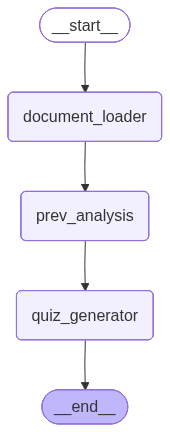

In [90]:
graph_builder.add_node("document_loader",document_loader)

graph_builder.add_node('prev_analysis', prev_analysis)

graph_builder.add_node('quiz_generator', quiz_generator)

graph_builder.add_edge(START, "document_loader")
graph_builder.add_edge("document_loader", 'prev_analysis')
graph_builder.add_edge('prev_analysis', 'quiz_generator')
graph_builder.add_edge('quiz_generator', END)

graph = graph_builder.compile()

from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [91]:
responce = graph.invoke({'messages': [{"role": "user","content": "complete the tasks"}]})






def extract_dict_from_string(s: str):
    # Extract the first {...} block from the string using regex
    match = re.search(r'\{.*\}', s, re.DOTALL)
    if not match:
        return None  # No dictionary found

    dict_str = match.group(0)

    try:
        # Safely evaluate string to Python dict (no code execution)
        return ast.literal_eval(dict_str)
    except Exception:
        return None


# print(extract_dict_from_string(responce['messages'][-2].content))
print("\n")

# print(responce['messages'][0].content)
print(extract_dict_from_string(responce['messages'][-1].content))


# print(responce['messages'])



{'quiz': [{'question': "What does Newton's Third Law of Motion primarily state?", 'options': ['An object at rest stays at rest.', 'Force equals mass times acceleration.', 'For every action, there is an equal and opposite reaction.', 'Gravity attracts objects to each other.'], 'answer': 'For every action, there is an equal and opposite reaction.', 'explanation': "Newton's Third Law specifically states that forces always occur in pairs, with each force being equal in magnitude and opposite in direction."}, {'question': 'When you push against a wall, what is the reaction force?', 'options': ['The wall pushing back on you.', 'The wall moving away from you.', 'Your hand feeling tired.', 'The force of gravity acting on you.'], 'answer': 'The wall pushing back on you.', 'explanation': "According to Newton's Third Law, if you exert a force on the wall (action), the wall exerts an equal and opposite force back on you (reaction)."}, {'question': 'A swimmer pushes water backward with her arms a

In [92]:
model.invoke("hello")

AIMessage(content='Hello! How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--4a1e9ed0-28ca-4926-8337-4c3dfc328e5e-0', usage_metadata={'input_tokens': 2, 'output_tokens': 450, 'total_tokens': 452, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 441}})

In [93]:
wrong_attempts = {

          "quiz_topic": "Newtons 3rd law of motion",
          "total_score": "3",
          "total_marks_of_exam": "5",
          "date": "22/08/2024",
          "student_id": "in12456",
          "wrong_questions": {
                "1": {"question": "When you push a wall, what is the reaction force according to Newton's Third Law?", "student_answer": "The wall absorbs your force.", "correct_answer": "The wall pushes back on you with an equal and opposite force.", "explanation": "According to the Third Law, if you exert a force (action) on the wall, the wall exerts an equal and opposite force (reaction) back on you."},
                "2": {"question": "Action and reaction forces described by Newton's Third Law always act on:", "student_answer": "The same object.", "correct_answer": "Different objects.", "explanation": "It's crucial to understand that action and reaction forces never cancel each other out because they always act on two different interacting objects."}

             }


     }

syllabus = {

        "chapters": {

            "1": "newtons 1st law of motion",
            "2": "newtons 2nd law of motion",
            "3": "newtons 3rd law of motion",
            "4": "Rotational dynamics",
            "5": "Fluid dynamics"

        }

}

class State(TypedDict):
        messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

# Quiz results analyser which will analize the results of quiz, summarize the student performanace, save into database for future purposes, guide the students

In [94]:
def quiz_analysis(state: State):

            system_template = "you are a good teacher, you need to give analysis of student performance in quiz on given topic: {topic}. these details are in python dictionary format and for each wrong question we have question, student_answer, correct_answer and explanation why that answer is correct. based on these details you need to give analysis of student performance in quiz and what topics student need to revise or imporve. if he is performed good in this quiz suggest next topic according to syllabus, syllabus is {syllabus} . output should be in json format only like this ('revision_reqired_topics': '','suggestions_to_improve': '','next_topics_to_study':'') consider the json format which i given as curve bracked are replaced with flower brackets."

            user_message = "quiz details are {wrong_attempts}"

            prompt_template = ChatPromptTemplate.from_messages([

                    ("system", system_template),
                    ("user", user_message)

                ])


            prompt = prompt_template.invoke({"topic": wrong_attempts['quiz_topic'],"wrong_attempts": wrong_attempts,"syllabus": syllabus})

            responce = model.invoke(prompt)





            return {'messages': [responce.content]}

In [95]:
def data_saver(state: State):





        system_template = "you are a good teacher, you need to mention the topic of each wrong question in quiz on given topic: {topic}. these details are in pyhton dictionary format and for each wrong question we have question, student_answer, correct_answer and explanation why that answer is correct. based on these details you need to give topic of each wrong question. output should be a python list format only like this ['topic1','topic2',....]."

        user_message = "quiz details are {wrong_attempts}"

        prompt_template = ChatPromptTemplate.from_messages([

                    ("system", system_template),
                    ("user", user_message)

                ])


        prompt = prompt_template.invoke({"topic": wrong_attempts['quiz_topic'],"wrong_attempts": wrong_attempts})

        responce = model.invoke(prompt)


        # content need to save in database











        return {'messages': [responce.content]}

In [96]:
def extract_list_from_string(s: str):
    # Extract the first {...} block from the string using regex
    match = re.search(r'\[.*\]', s, re.DOTALL)
    if not match:
        return None  # No dictionary found

    dict_str = match.group(0)

    try:
        # Safely evaluate string to Python list (no code execution)
        return ast.literal_eval(dict_str)
    except Exception:
        return None

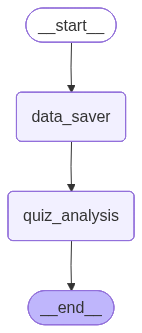

In [97]:
graph_builder.add_node("data_saver",data_saver)
graph_builder.add_node('quiz_analysis', quiz_analysis)

graph_builder.add_edge(START, "data_saver")

# graph_builder.add_edge(START, "quiz_analysis")



graph_builder.add_edge("data_saver", 'quiz_analysis')

graph_builder.add_edge('quiz_analysis', END)


graph = graph_builder.compile()


from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [98]:
responce = graph.invoke({'messages': [{"role": "user","content": "complete the tasks"}]})

print(extract_list_from_string(responce['messages'][-2].content))

print("\n")


print(extract_dict_from_string(responce['messages'][-1].content))
# print(responce['messages'])

['Identifying the Reaction Force', 'Objects on which Action-Reaction Forces Act']


{'revision_reqired_topics': "The student needs to revise the fundamental principles of Newton's Third Law of Motion, specifically focusing on:\n1.  **Nature of Action-Reaction Pairs:** Understanding that a reaction force is an equal and opposite force, not an absorption of force.\n2.  **Objects of Interaction:** Clearly understanding that action and reaction forces always act on *different* interacting objects, not the same object. This is a crucial distinction that prevents forces from cancelling each other out.", 'suggestions_to_improve': "To improve understanding, the student should:\n1.  **Revisit the definitions:** Go over the precise definition of Newton's Third Law and its implications.\n2.  **Practice identifying pairs:** Work through various examples to identify action-reaction force pairs (e.g., a rocket taking off, a person walking, a bird flying, a book resting on a table).\n3.  **Use diagra

# Documents analyser which are uploader by the Teacher

it wil extract the data from documents which are extracted by the teacher and save that data into the database to use it for guiding students


In [99]:
import base64
import httpx


# type can be syllabus or circulum or notes or reference


# docs type need to extract from form data

type = ""



doc_details = {

               "type": "syllabus",


}


# type = doc_details['type']





sys_mess = 'you are a good teacher, you new analysis the document. it may syllabus or Notes or reference document. if doument is syllabus or circulum doument then extract the content of what are the chapters and what are the subtopics in each chapter and give output as ("chapters": ( "chapter1_name": ("subtopics": ["topic1","topic2", ..]), "chapter2_name": ("subtopics": ["topic1","topic2", ..]),.. )), in this case case output should be a python dictionary.consider the python dictionary format which i given as curve bracked are replaced with flower brackets . if document is notes or reference document then extract the content of what topics convered in the document and give output as ["topics1","topic2", ..] in this case output should be a pyhon list. strictly dont add any extra content in output'
user_mess = f" given doument is a {type} document"

message = {
            "role": "user",
            "content": [
                            {
                            "type": "text",
                            "text": sys_mess
                                },

                            {
                                "type": "text",
                                "text": user_mess
                            },




                        ],
                }



pdf_url = "https://gatenotes.in/GATE-Syllabus-New/GATE-Syllabus-MA%20Mathematics(www.gatenotes.in).pdf"


# with open("myfile.pdf", "rb") as f:
#     pdf_data = base64.b64encode(f.read()).decode("utf-8")


pdf_data = base64.b64encode(httpx.get(pdf_url).content).decode("utf-8")




docs_file = {

              "type": "file",
              "source_type": "base64",
              "data": pdf_data,
              "mime_type": "application/pdf",

}


message['content'] = message['content'] + [docs_file]





responce = model.invoke([message])



if type == "syllabus" or type == "circulum":

    data_extracted = extract_dict_from_string(responce['messages'][-2].content)

    doc_details = doc_details + data_extracted

elif type == "notes" or type == "reference":



    data_extracted = extract_list_from_string(responce['messages'][-2].content)

    doc_details = doc_details + data_extracted



# save this doc_details in discription columbn of databse












## Persionalized ChatBot which can access the student previous performance and guide according to them

In [100]:
from langgraph.checkpoint.memory import InMemorySaver


class State(TypedDict):

  messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

memory = InMemorySaver()

config = {"configurable": {"thread_id": "1"}}


def chatbot(state: State):
    return {"messages": [model.invoke(state["messages"],config)]}

graph_builder.add_node("chatbot", chatbot)

graph_builder.add_edge(START,"chatbot")



graph = graph_builder.compile(checkpointer=memory)


In [101]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [102]:
result = graph.invoke({"messages": [{"role": "user", "content": "guide me"}]},config)